In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import statistics as stat
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pyodbc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [95]:
transaction_df = pd.read_csv('transaction_merged.csv')

In [103]:
#print(transaction_df.select_dtypes(include='object').columns)
print(transaction_df.dtypes)

COMPANY               object
BRANCH                object
OPERATION_CORE_ID     object
PRODUCT_ID             int64
OPERATION_CODE         int64
OPERATION_DATE         int32
CURRENCY              object
CURRENCY_AMOUNT      float64
AMOUNT               float64
ACCOUNT_ID             int64
CUST_ID                int64
DEBIT_CREDIT_FLAG     object
RISK_LEVEL             int64
STATE                 object
FISCAL_COUNTRY        object
ACCOUNT_CURRENCY      object
BALANCE              float64
ACCOUNT_TYPE         float64
PRODUCT_CODE         float64
dtype: object


The dataset has 5 columns that are in Object datatype which needs to be converted into Float/Integer datatype for further analysis & Model building.  As K-Nearest Model to be used for the Fraud Detection process, it is essential to drop.
Columns:
    1. ID
    2. OPERATION_CODE
    3. OPERATION_DATE
    4. TRANSACTION_REF
    5. OPEN_DATE

In [98]:
#convert OPERATION_DATE & OPEN_DATE into timestamp

transaction_df['OPERATION_DATE']=pd.to_datetime(transaction_df['OPERATION_DATE'])
transaction_df['OPERATION_DATE'] = transaction_df['OPERATION_DATE'].apply(lambda x:x.timestamp())
transaction_df['OPERATION_DATE']=transaction_df['OPERATION_DATE'].astype(int)
print(transaction_df['OPERATION_DATE'].head())

0    1700784000
1    1649721600
2    1686614400
3    1710460800
4    1712016000
Name: OPERATION_DATE, dtype: int32


In [ ]:
transaction_df['OPEN_DATE']=pd.to_datetime(transaction_df['OPEN_DATE'])
transaction_df['OPEN_DATE'] = transaction_df['OPEN_DATE'].apply(lambda x:x.timestamp())
transaction_df['OPEN_DATE']=transaction_df['OPEN_DATE'].astype(int)
print(transaction_df['OPEN_DATE'].head())

In [94]:
#convert OPERATION_CODE column to int

transaction_df['OPERATION_CODE'] = transaction_df['OPERATION_CODE'].astype(int)
print(transaction_df['OPERATION_CODE'].head())

0    5028
1    5025
2    5025
3    5025
4     833
Name: OPERATION_CODE, dtype: int32


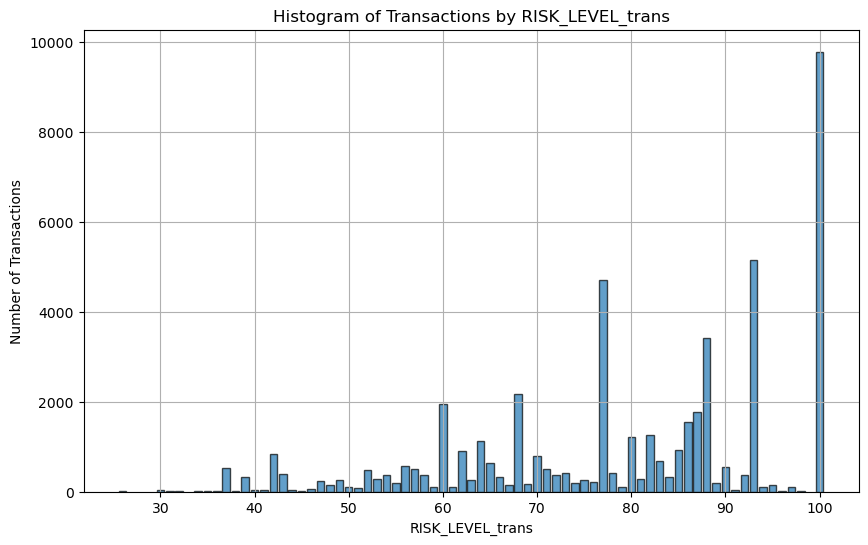

In [15]:
risk_level_counts = transaction_df['RISK_LEVEL'].value_counts().sort_index()

# Plot the histogram for RISK_LEVEL_trans
plt.figure(figsize=(10, 6))
plt.bar(risk_level_counts.index, risk_level_counts.values, edgecolor='black', alpha=0.7)
plt.title('Histogram of Transactions by RISK_LEVEL_trans')
plt.xlabel('RISK_LEVEL_trans')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.show()

In [ ]:
to_drop_columns=['ID', 'OPEN_DATE', 'TRANSACTION_REF']
transaction_df=transaction_df.drop(columns = to_drop_columns)

In [102]:
print(transaction_df.head(10))

  COMPANY BRANCH            OPERATION_CORE_ID  PRODUCT_ID  OPERATION_CODE  \
0       A      A       204175051344051.000001        6003            5028   
1       A      A       198422458543585.010002        5001            5025   
2       A      A  F20230613.20253237702783302        6001            5025   
3       A      A       205298009845918.010001        5001            5025   
4       A      A       205505486832926.020001        6001             833   
5       A      A       205697690339258.170001        6001             816   
6       A      A       196540853336430.010002        5001            5025   
7       A      A       196812252535598.050001        5001            5027   
8       A      A       204195399826261.010001        5001            5045   
9       A      A       199811986054970.000001        6003            5028   

   OPERATION_DATE CURRENCY  CURRENCY_AMOUNT     AMOUNT   ACCOUNT_ID  CUST_ID  \
0      1700784000      USD        200000.00  200000.00  10000001908  100

In [ ]:
label_cols = ['COMPANY', 'BRANCH', 'CURRENCY', 'DEBIT_CREDIT_FLAG',  'FISCAL_COUNTRY', 'ACCOUNT_CURRENCY', 'STATE', 'FISCAL_COUNTRY']
label_encoder = LabelEncoder()

for col in label_cols:
    transaction_df[col] = label_encoder.fit_transform(transaction_df[col])

# Compute the correlation matrix
correlation_matrix = transaction_df.corr()

correlation_threshold = 0.8
significant_columns = correlation_matrix.columns[correlation_matrix.abs().sum() > correlation_threshold]

# Filter the DataFrame to keep only significant columns
df_filtered = transaction_df[significant_columns]

# Plot the correlation matrix for the filtered DataFrame
plt.figure(figsize=(20, 15))
sns.heatmap(df_filtered.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Filtered Correlation Matrix')
plt.show()

# Display the significant columns
print("Significant columns for EDA and ML:")
print(significant_columns)

In [11]:
additional_percentiles=[0.90, 0.95, 0.96, 0.97, 0.98, 0.99]
#account_id = 10000000127
amount_summary=transaction_df.groupby('ACCOUNT_ID')['CURRENCY_AMOUNT'].describe(percentiles=additional_percentiles).round(2)
#print(amount_summary.loc[account_id, '98%'])
print(amount_summary)

             count       mean         std       min       50%        90%  \
ACCOUNT_ID                                                                 
10000000097    8.0     923.50      624.84    350.00    748.50    1847.00   
10000000103    2.0     341.61        0.00    341.61    341.61     341.61   
10000000111   47.0   51495.27   125007.48    100.00  14336.50   97340.00   
10000000127   35.0  151382.23   256026.56     49.42  41781.34  472550.74   
10000000138    2.0   61710.50        0.00  61710.50  61710.50   61710.50   
...            ...        ...         ...       ...       ...        ...   
80000000213    4.0      62.20        0.00     62.20     62.20      62.20   
80000000217    4.0    1172.54        0.00   1172.54   1172.54    1172.54   
80000000234    4.0     360.00        0.00    360.00    360.00     360.00   
80000000242   74.0  553209.63  2709850.88      2.25   6702.75  236762.68   
80000000243    2.0    1740.53        0.00   1740.53   1740.53    1740.53   

           

In [12]:
for transaction_index, transaction_row in transaction_df.iterrows():
    if transaction_df.loc[transaction_index,'CURRENCY_AMOUNT'] > amount_summary.loc[transaction_df.loc[transaction_index, 'ACCOUNT_ID'],'99%'] and transaction_df.loc[transaction_index,'RISK_LEVEL']>60:
        transaction_df.loc[transaction_index,'FRAUD'] = 1
    else:
        transaction_df.loc[transaction_index,'FRAUD'] = 0

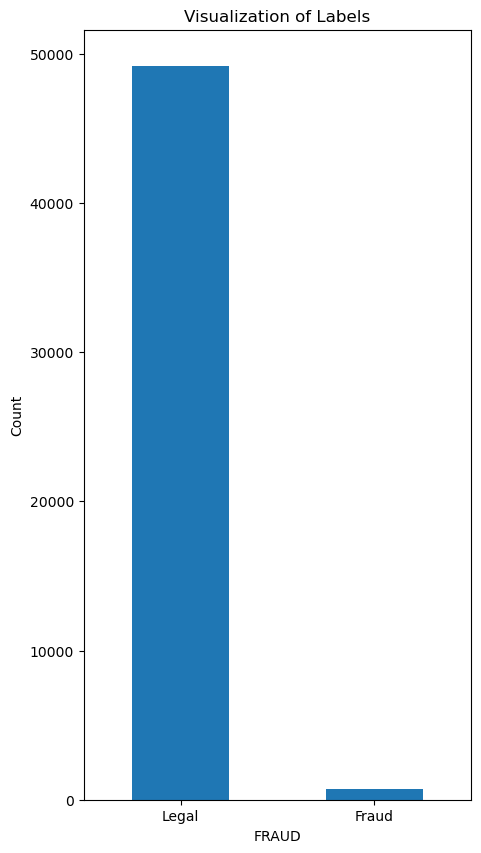

In [22]:
plt.figure(figsize=(5,10))
labels = ["Legal", "Fraud"]
count_classes = transaction_df.value_counts(transaction_df['FRAUD'], sort= True)
count_classes.plot(kind = "bar", rot = 0)
plt.title("Visualization of Labels")
plt.ylabel("Count")
plt.xticks(range(2), labels)
plt.show()

In [25]:
print(transaction_df.dtypes)

ID                    object
COMPANY                int64
BRANCH                 int64
OPERATION_CORE_ID     object
PRODUCT_ID             int64
OPERATION_CODE         int64
OPERATION_DATE        object
CURRENCY               int64
CURRENCY_AMOUNT      float64
AMOUNT               float64
ACCOUNT_ID             int64
CUST_ID                int64
DEBIT_CREDIT_FLAG      int64
TRANSACTION_REF       object
RISK_LEVEL             int64
STATE                  int64
FISCAL_COUNTRY         int64
OPEN_DATE             object
ACCOUNT_CURRENCY       int64
BALANCE              float64
ACCOUNT_TYPE         float64
PRODUCT_CODE         float64
FRAUD                float64
dtype: object
